In [ ]:
 !apt-get install -y portaudio19-dev
!pip install sounddevice


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


# Model Tranning

Mounted at /content/drive
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 318ms/step - accuracy: 0.1657 - loss: 2.1954 - val_accuracy: 0.1511 - val_loss: 2.1613
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.2226 - loss: 2.0441 - val_accuracy: 0.1511 - val_loss: 2.1548
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.3556 - loss: 1.8647 - val_accuracy: 0.1867 - val_loss: 2.1370
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.3917 - loss: 1.7212 - val_accuracy: 0.3467 - val_loss: 2.1104
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.4127 - loss: 1.6466 - val_accuracy: 0.3378 - val_loss: 2.0814
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.4559 - loss: 1.5374 - val_accuracy: 0.1822 - val_loss: 2.1037
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.4845 - loss: 1.4486 - val_accuracy: 0.1956 - val_loss: 2.0835
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.5068 -

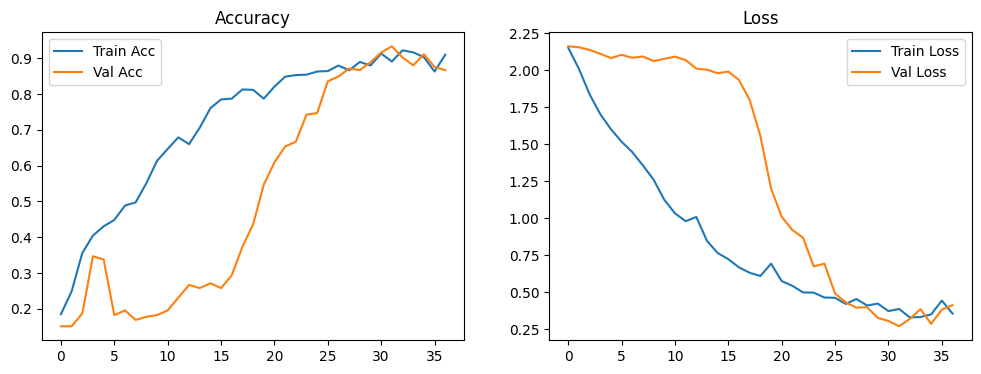

✅ Model trained with Early Stopping and saved successfully!


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, GRU, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Mount Google Drive (for Colab users)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define paths
main_folder = "/content/drive/My Drive/hackathon_projects/flute_guide/flute_teaching_kit/data/processed_data"
model_path = "/content/drive/My Drive/hackathon_projects/flute_guide/flute_teaching_kit/model/crnn_model_final.keras"

# Load Data
X, y = [], []

for note in sorted(os.listdir(main_folder)):
    note_path = os.path.join(main_folder, note)

    if os.path.isdir(note_path):
        for file in sorted(os.listdir(note_path)):
            if file.endswith(".npy"):
                data = np.load(os.path.join(note_path, file))
                X.append(data)
                y.append(note)

X = np.array(X)
y = LabelEncoder().fit_transform(y)

# Normalize data
X = X / np.max(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Reshape for CNN input
X_train = X_train[..., np.newaxis]  # Shape: (samples, height, width, 1)
X_val = X_val[..., np.newaxis]

# Define Model
input_shape = X_train.shape[1:]

model = Sequential([
    tf.keras.Input(shape=input_shape),

    # CNN Layers
    Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Reshape CNN output for GRU
    Reshape((-1, 32)),  # Adjust last dimension to fit GRU input (timesteps, features)

    # RNN Layer (GRU)
    Bidirectional(GRU(32)),

    # Fully Connected Layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train Model with Early Stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

# Plot Accuracy and Loss
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

# Save Model in .keras format
model.save(model_path, save_format="keras")

# 🔹 Load & Verify Model
print("✅ Model trained with Early Stopping and saved successfully!")

# Implemantation

In [ ]:
import numpy as np
import pandas as pd
import librosa
import glob
import sounddevice as sd
import wave
import tensorflow as tf
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'sounddevice'

In [ ]:
## take audio input

def record_audio(filename, duration, samplerate=44100):
    print("Recording...")
    audio_data = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=2, dtype=np.int16)
    sd.wait()
    print("Recording finished.")

    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(2)
        wf.setsampwidth(2)
        wf.setframerate(samplerate)
        wf.writeframes(audio_data.tobytes())

In [ ]:
import librosa
import numpy as np

def data_extraction(file_path):
    data = []
    y, sr = librosa.load(file_path, sr=None)  # Load with original sampling rate
    print("Audio length:", len(y))

    intervals = librosa.effects.split(y, top_db=30)  # Detect non-silent regions
    mean_sample_size = 14346

    series_y = pd.Series(y)
    series_y.plot(figsize=(10, 5))
    plt.show()

    for interval in intervals:
        start, end = interval
        interval_size = end - start
        num_notes = interval_size // mean_sample_size
        print("Notes in interval:", num_notes)

        remain = interval_size - num_notes * mean_sample_size
        shift = remain // 2 if remain >= 0.5 * mean_sample_size else 0

        for i in range(num_notes):
            mid = start + (i * mean_sample_size) + shift
            y_sample = y[mid : mid + mean_sample_size]

            if len(y_sample) < mean_sample_size:
                continue  # Skip if the sample is too short

            # Compute Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y_sample, sr=sr, n_mels=128)
            sound_db_sample = librosa.power_to_db(mel_spec, ref=np.max)

            # Normalize to range [0,1]
            sound_db_sample = np.clip(sound_db_sample, -80, 0)
            sound_db_sample = (sound_db_sample + 80) / 80

            min_val, max_val = np.min(sound_db_sample), np.max(sound_db_sample)
            if min_val != max_val:
                sound_db_sample = (sound_db_sample - min_val) / (max_val - min_val)
            else:
                sound_db_sample = np.zeros_like(sound_db_sample)

            data.append(sound_db_sample)

    return data

In [ ]:
record_audio("output.wav", duration=5)

Recording...


NameError: name 'sd' is not defined

In [ ]:
file_path = r"/content/drive/My Drive/hackathon_projects/flute_guide/flute_teaching_kit/model/test_1.wav"

Audio length: 583296


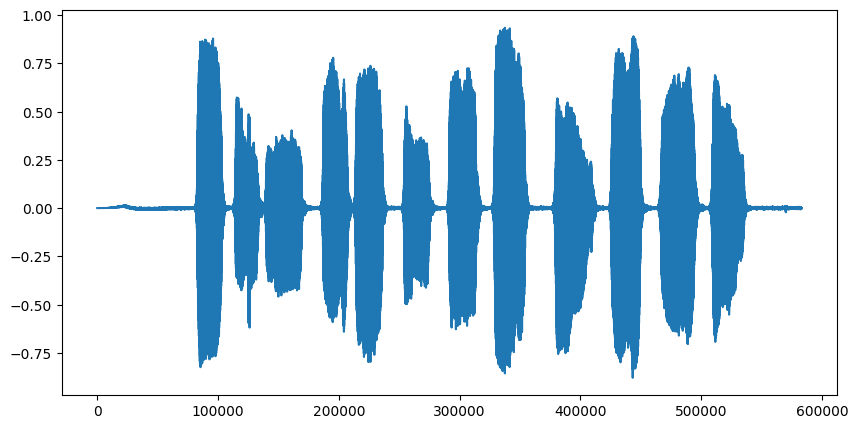

Notes in interval: 1
Notes in interval: 1
Notes in interval: 2
Notes in interval: 1
Notes in interval: 1
Notes in interval: 1
Notes in interval: 1
Notes in interval: 2
Notes in interval: 2
Notes in interval: 1
Notes in interval: 2
Notes in interval: 2


In [ ]:
data = data_extraction(file_path)

In [ ]:
# Convert extracted data into a NumPy array
X_test = np.array(data)

# Reshape to match the model's expected input shape: (batch, height, width, channels)
X_test = X_test.reshape(X_test.shape[0], 128, 29, 1)  # Ensure 128 matches the Mel spectrogram height

# Make predictions
predictions = model.predict(X_test)

# Get the predicted class
predicted_classes = np.argmax(predictions, axis=1)  # Returns the index of the highest probability
print("Predicted Classes:", predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
Predicted Classes: [0 6 6 6 0 4 6 0 0 0 4 4 0 4 0 4 4]
